- [Understanding Prioritized Experience Replay](https://danieltakeshi.github.io/2019/07/14/per/)

依据`TD-Error` $\delta_{t}$的不同给样本添加优先级，此时记忆库中存储的数据格式在原`DQN`系列中存储的格式中，还要添加一个优先级:

$$
\left(s_{t}, a_{t}, r_{t}, s_{t+1},\left|\delta_{t}\right|\right)
$$

每次更新网络，是否要更新记忆库中样本`TD-Error`误差的大小呢？将优先级定义为$p_{i}$, 其定义有两种方式:

1. `rank based`的方法: $p_{i} = \frac{1}{rank(i)}$。

2. `proportional variant`的方法: $p_{i} = |\delta_{i}| + \epsilon$



在探索的过程中，智能体一直在采样，$p_{i}$并不能计算得到，此时，采用到目前为止所有优先级最大的那个值，作为当前样本的优先级。之后就可以依据这个优先级来构建采样样本的分布概率$P(i)$:

$$
P(i)=\frac{p_{i}^{\alpha}}{\sum_{k} p_{k}^{\alpha}}
$$

可以看到，当$\alpha=0$时，没有优先级这个概念，所有样本都是等概率被采样的，当$\alpha=1$时，就是全优先级的采样。

当采用全优先级，$\alpha=1$时，可能会产生过拟合这种问题，智能体只学习少部分样本，熵也比较低。并且还改变了采样的分布。

DQN和QLearning中是没有重要性采样的，但是这里加了一个，

$$
w_{i}=\left(\frac{1}{N} \cdot \frac{1}{P(i)}\right)^{\beta}
$$

In [1]:
import gym
env = gym.make("CartPole-v0")

In [2]:
import numpy as np
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        state, action, reward, next_state, done = zip(*samples)
        states      = np.concatenate(state)
        actions     = action
        rewards     = reward
        next_states = np.concatenate(next_state)
        dones       = done
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

In [3]:
replay_buffer = NaivePrioritizedBuffer(100000)

In [4]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

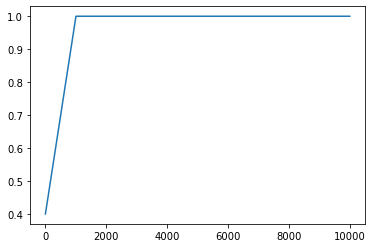

In [5]:
import matplotlib.pyplot as plt
plt.plot([beta_by_frame(i) for i in range(10000)])

In [6]:
import math

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

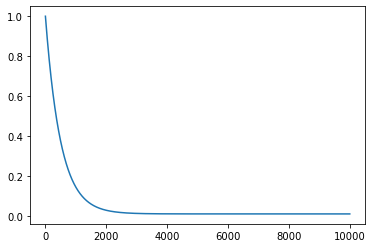

In [7]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [8]:
import torch.nn as nn
import random

class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].numpy()[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [9]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
current_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n).to(device)

In [10]:
import torch.optim as optim
optimizer = optim.Adam(current_model.parameters())

In [11]:
def update_target(current, target):
    target.load_state_dict(current.state_dict())
update_target(current_model, target_model)

In [12]:
def compute_td_loss(batch_size, beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta) 

    state      = torch.FloatTensor(np.float32(state))
    next_state = torch.FloatTensor(np.float32(next_state))
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)
    weights    = torch.FloatTensor(weights)

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss  = (q_value - expected_q_value.detach()).pow(2) * weights
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()
    
    return loss

In [13]:
from IPython.display import clear_output

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

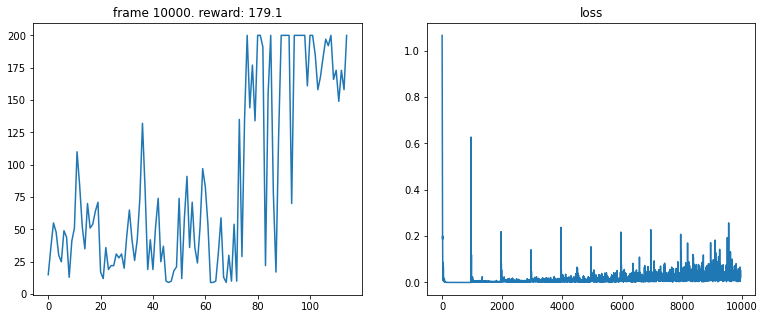

In [14]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(batch_size, beta)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)